# Labeling Images That Have Weapon/Knife Content
 *by Yusuf GÜR (2532810)*


## Introduction

This notebook implements a fight labelling in crowd areas, especially in stadiums.


## Notes

The dataset is located in the link below.
https://we.tl/t-yHftCY3Cg3

It can be downloaded, unzipped and used for training

The trained weights are also located in this link:
https://we.tl/t-94m9JBxB5q

## Imports

In [1]:
# required libraries for the model
from numpy.random import seed, shuffle
import numpy as np
import matplotlib.pyplot as plt
import time as tm 
import sys
import logging
import cv2
import time as tm
%matplotlib inline

# Imports
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
from torch.optim import lr_scheduler  #
import torch.nn.functional as F  # All functions that don't have any parameters
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
from torchvision import datasets, models, transforms
from torch.utils.data import (DataLoader,DataLoader)  # Gives easier dataset managment and creates mini batches
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import torchvision
import os
import pandas as pd
from skimage import io

from google.colab import drive

import shutil
import copy

**Setting**  Device and **Initiating** Google_Drive

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Connect Drive 
drive.mount("/content/gdrive")
# I am using my own Google Drive. All files are in labIssues folder
dataset_path = '/content/gdrive/MyDrive/METU/01.courses/METU_MMI_727/project/source'

Mounted at /content/gdrive


## Prepare Datasets

In [ ]:
#!rm -r /content/gdrive/MyDrive/METU/01.courses/METU_MMI_727/project/source_new
#!rm -r /content/source_new
#%cd /content/gdrive/MyDrive/METU/01.courses/METU_MMI_727/project/source
#%cp -av directorySource directoryTarget  # using linux terminal
#!rm -r /content/source
#!rm -r /content/test
#!rm -r /content/train
#!rm -r /content/val

rm: cannot remove '/content/source': No such file or directory


# Functions to be used for preparing Datasets

In [3]:
# Checking source and destination file sizes if some files missed
def countFiles(directorySource,directoryDestination):
  fileSrc = os.listdir(directorySource) # fileSrc is source directory path
  fileDst = os.listdir(directoryDestination) # fileDst is destination directory path
  print("Source Folder Length:",len(fileSrc),"Destination Folder Length:",len(fileDst))

In [4]:
# Using linux terminal to transfer files from one path to another
def linuxMove(src,dst,Src,Dst):
  directorySrc=src+Src
  directoryDst=dst+Dst
  %mv -b $directorySrc $directoryDst  # using linux terminal
  countFiles(directorySrc,directoryDst)

In [5]:
# Using linux terminal to transfer files from one path to another
def linuxCopy(src,dst,Src,Dst):
  directorySrc=src+Src
  directoryDst=dst+Dst
  if not os.path.exists(directoryDst):
    os.makedirs(directoryDst)
  %cp -ar $directorySrc/* $directoryDst  # using linux terminal
  countFiles(directorySrc,directoryDst)

In [6]:
# preparing data paths to copy from gdrive
src="/content/gdrive/MyDrive/METU/01.courses/METU_MMI_727/project/source"
dst="/content/source"
#dst="/content/gdrive/MyDrive/METU/01.courses/METU_MMI_727/project"

knifeImgSrc='/Knife_Detection/Images'
knifeImgDst='/images/Knifes'
knifeAntSrc='/Knife_Detection/Annotations'
knifeAntDst='/annotations/Knifes_annotations'
weaponImgSrc='/Weapon_Detection/Images'
weaponImgDst='/images/Weapons'
weaponAntSrc='/Weapon_Detection/Annotations'
weaponAntDst='/annotations/Weapons_annotations'

if not os.path.exists(dst):
  os.makedirs(dst)

Src=[knifeImgSrc,knifeAntSrc,weaponImgSrc,weaponAntSrc]
Dst=[knifeImgDst,knifeAntDst,weaponImgDst,weaponAntDst]

In [ ]:
'''
start_time = tm.time() 
for i in range(len(Src)):
  linuxMove(src,dst,SrcAnt[i],DstAnt[i])
end_time = tm.time()                                                                               
duration_time = np.subtract(end_time, start_time)
print('Duration of Copy {:.0f}m {:.0f}s'.format(
        duration_time // 60, duration_time % 60))
'''

"\nstart_time = tm.time() \nfor i in range(len(Src)):\n  linuxMove(src,dst,SrcAnt[i],DstAnt[i])\nend_time = tm.time()                                                                               \nduration_time = np.subtract(end_time, start_time)\nprint('Duration of Copy {:.0f}m {:.0f}s'.format(\n        duration_time // 60, duration_time % 60))\n"

In [7]:
# copy folders into colab
start_time = tm.time() 
for i in range(len(Src)):
  linuxCopy(src,dst,Src[i],Dst[i])
end_time = tm.time()                                                                               
duration_time = np.subtract(end_time, start_time)
print('Duration of Copy {:.0f}m {:.0f}s'.format(
        duration_time // 60, duration_time % 60))

Source Folder Length: 2078 Destination Folder Length: 2078
Source Folder Length: 2078 Destination Folder Length: 2078
Source Folder Length: 3000 Destination Folder Length: 3000
Source Folder Length: 3000 Destination Folder Length: 3000
Duration of Copy 61m 13s


# Splitting dataset into train, test and validation

In [8]:
# Defining the function to be used
def split_dataset(path_to_dataset, train_ratio, valid_ratio):
    #split the dataset in the given path into three subsets(test,val,train)
    _, sub_dirs, _ = next(iter(os.walk(path_to_dataset)))  # retrieve name of subdirectories
    sub_dir_item_cnt = [0 for i in range(len(sub_dirs))]  # list for counting items in each sub directory(class)

    # directories where the splitted dataset will copy
    dir_train = os.path.join(os.path.dirname(path_to_dataset), 'train')
    dir_test = os.path.join(os.path.dirname(path_to_dataset), 'test')
    dir_valid = os.path.join(os.path.dirname(path_to_dataset), 'val')
    

    for i, sub_dir in enumerate(sub_dirs):  # walking on all sub directories

        dir_train_dst = os.path.join(dir_train, sub_dir)  # directory for destination of train dataset
        dir_test_dst = os.path.join(dir_test, sub_dir)  # directory for destination of test dataset
        dir_valid_dst = os.path.join(dir_valid, sub_dir)  # directory for destination of validation dataset
        
        # variables to save the sub directory name(class name) and to count the images of each sub directory(class)
        class_name = sub_dir
        sub_dir = os.path.join(path_to_dataset, sub_dir)
        sub_dir_item_cnt[i] = len(os.listdir(sub_dir))

        items = os.listdir(sub_dir)

        # transfer data to trainset
        for item_idx in range(round(sub_dir_item_cnt[i] * train_ratio)):
            if not os.path.exists(dir_train_dst):
                os.makedirs(dir_train_dst)

            source_file = os.path.join(sub_dir, items[item_idx])
            dst_file = os.path.join(dir_train_dst, items[item_idx])
            shutil.copyfile(source_file, dst_file)

        # transfer data to testset
        for item_idx in range(round(sub_dir_item_cnt[i] * (train_ratio + valid_ratio)) + 1, sub_dir_item_cnt[i]):
            if not os.path.exists(dir_test_dst):
                os.makedirs(dir_test_dst)

            source_file = os.path.join(sub_dir, items[item_idx])
            dst_file = os.path.join(dir_test_dst, items[item_idx])
            shutil.copyfile(source_file, dst_file)

        # transfer data to validation
        for item_idx in range(round(sub_dir_item_cnt[i] * train_ratio) + 1,
                              round(sub_dir_item_cnt[i] * (train_ratio + valid_ratio))):
            if not os.path.exists(dir_valid_dst):
                os.makedirs(dir_valid_dst)

            source_file = os.path.join(sub_dir, items[item_idx])
            dst_file = os.path.join(dir_valid_dst, items[item_idx])
            shutil.copyfile(source_file, dst_file)
    return





In [9]:
#Splitting data into 3 sets
path_to_dataset="/content/source/images"
train_ratio=0.7
valid_ratio=0.15
split_dataset(path_to_dataset, train_ratio, valid_ratio)

In [10]:
#Checking data sizes in each 3 sets
dstTrain="/content/source/train"
dstTest="/content/source/test"
dstValidation="/content/source/val"

knifeDst='/Knifes'
weaponDst='/Weapons'

Folders=[dstTrain,dstTest,dstValidation]
Dst=[knifeDst,weaponDst]

for i in range(len(Folders)):
  for j in range(len(Dst)):
    directoryDst=Folders[i]+Dst[j]
    fileDst = os.listdir(directoryDst) # fileDst is directory path
    print(directoryDst,"Folder Length:",len(fileDst))


/content/source/train/Knifes Folder Length: 1455
/content/source/train/Weapons Folder Length: 2100
/content/source/test/Knifes Folder Length: 311
/content/source/test/Weapons Folder Length: 449
/content/source/val/Knifes Folder Length: 310
/content/source/val/Weapons Folder Length: 449


# Define Transfoms Functions

In [11]:
#------------- (Dataset Transforms)---------------------------------#
# 1) Resize image to H x W
# 2) Convert image to torch tensor.
# 3) Normalize the tensor.
#-------------------------------------------------------------------#

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

#Imshow for Tensor.
def imshow(img, title):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.show()



## Define Hyperparamaters to be used

In [16]:
## Models for Transfer Learning
resnet18 = models.resnet18(pretrained=True)
print(resnet18)
alexnet = models.alexnet(pretrained=True)
print(alexnet)
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [32]:
## Transfer Learning aproaches
transferLearnings=['fromScratch','fineTune']
## Transfer Learning aproaches
#architectures=[resnet18, alexnet, vgg16]
architectures=[alexnet, vgg16]
## Transfer Learning aproaches
#dropouts=[0.0,0.1,0.2]
dropouts=[0.0,0.2]
## Transfer Learning aproaches
#learningRates=[1e-4 , 1e-3, 1e-2]
learningRates=[1e-4 , 1e-3,]
## Learning Schedulers
#learningSchedulerSteps=[2,5,10]
learningSchedulerSteps=[2,5]
## Epochs used with Learning Schedulers according to order
#epochs=[10,20,30]
epochs=[10,20]
## Batch Sizes
#batchSizes=[4,16,64]
batchSizes=[16,64]
## Loss Functions
criterion=nn.CrossEntropyLoss()
## Optimizer
optimizer=optim.SGD


In [22]:
'''
# classifiers for each model to be used in transfer learning

resnetClassifier=nn.Sequential(
                        nn.Linear(512,10),
                        nn.ReLU(),
                        nn.BatchNorm1d(10),
                        nn.Dropout(dropOut),
                        nn.Linear(10,2),
)

alexnetClassifier= nn.Sequential(
				                nn.Dropout(dropOut),
                        nn.Linear(9216, 4096),
                        nn.ReLU(),
                        nn.Dropout(dropOut),
                        nn.Linear(4096, 1000),
                        nn.ReLU(),
                        nn.Dropout(dropOut),
                        nn.Linear(1000,10),
                        nn.ReLU(),
                        nn.Dropout(dropOut),
                        nn.Linear(10,2),
)

vgg16netClassifier= nn.Sequential(
				                nn.Dropout(dropOut),
                        nn.Linear(25088, 4096),
                        nn.ReLU(),
                        nn.Dropout(dropOut),
                        nn.Linear(4096, 1000),
                        nn.ReLU(),
                        nn.Dropout(dropOut),
                        nn.Linear(1000,10),
                        nn.ReLU(),
                        nn.Dropout(dropOut),
                        nn.Linear(10,2),
)
'''

'\n# classifiers for each model to be used in transfer learning\n\nresnetClassifier=nn.Sequential(\n                        nn.Linear(512,10),\n                        nn.ReLU(),\n                        nn.BatchNorm1d(10),\n                        nn.Dropout(dropOut),\n                        nn.Linear(10,2),\n)\n\nalexnetClassifier= nn.Sequential(\n\t\t\t\t                nn.Dropout(dropOut),\n                        nn.Linear(9216, 4096),\n                        nn.ReLU(),\n                        nn.Dropout(dropOut),\n                        nn.Linear(4096, 1000),\n                        nn.ReLU(),\n                        nn.Dropout(dropOut),\n                        nn.Linear(1000,10),\n                        nn.ReLU(),\n                        nn.Dropout(dropOut),\n                        nn.Linear(10,2),\n)\n\nvgg16netClassifier= nn.Sequential(\n\t\t\t\t                nn.Dropout(dropOut),\n                        nn.Linear(25088, 4096),\n                        nn.ReLU(),\n

## Load Data

The data is imported to Colab from Google Drive 

Class Names: ['Knifes', 'Weapons']
Dataset sizes: {'train': 3555, 'test': 760, 'val': 759}


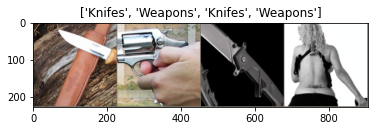

In [23]:
data_dir = '/content/source'
sets = ['train', 'test', 'val']

# defining datasets for each set
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in sets}
# defining dataloader for each set
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in sets}

# defining dataset sizes for each set
dataset_sizes = {x: len(image_datasets[x]) for x in sets}

# Target class names according to folder names
class_names = image_datasets['train'].classes

print("Class Names:",class_names)
print("Dataset sizes:",dataset_sizes)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# training  Model

In [24]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    #Start Timer
    start_time = tm.time()

    trainLoss=[]
    trainAccuracy=[]
    testLoss=[]
    testAccuracy=[]

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and test phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                trainLoss.append(epoch_loss) 
                trainAccuracy.append(epoch_acc)
            else:
                testLoss.append(epoch_loss) 
                testAccuracy.append(epoch_acc)

            #print to screen    
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    end_time = tm.time()
    duration_time = np.subtract(end_time, start_time) 

    print('Training complete in {:.0f}m {:.0f}s'.format(
        duration_time // 60, duration_time % 60))
    print('Best Test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,trainLoss, trainAccuracy, testLoss, testAccuracy, duration_time

In [ ]:
  for transferLearning in transferLearnings:
    for architecture in architectures:
      for dropOut in dropouts:
        for learningRate in learningRates:
          for batchSize in batchSizes:
            for epoch in epochs:
              # Load a pretrained model and reset final fully connected layer.
              model = architecture
              # Here, we need to freeze all the network except the final layer.
              # We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
              if (transferLearning=='fineTune'):
                for param in model.parameters():
                    param.requires_grad = False
              # Define new classifier according to binary output. # Parameters of newly constructed modules have requires_grad=True by default
              if (architecture==resnet18):
                modelName='resnet18'
                model.fc = nn.Sequential(
                                nn.Linear(512,10),
                                nn.ReLU(),
                                nn.BatchNorm1d(10),
                                nn.Dropout(dropOut),
                                nn.Linear(10,2),
              )
              elif (architecture==alexnet):
                modelName='alexnet'
                model.classifier = nn.Sequential(
                                nn.Dropout(dropOut),
                                nn.Linear(9216, 4096),
                                nn.ReLU(),
                                nn.Dropout(dropOut),
                                nn.Linear(4096, 1000),
                                nn.ReLU(),
                                nn.Dropout(dropOut),
                                nn.Linear(1000,10),
                                nn.ReLU(),
                                nn.Dropout(dropOut),
                                nn.Linear(10,2),
              )
              elif (architecture==vgg16):
                modelName='vgg16'
                model.classifier =  nn.Sequential(
                                nn.Dropout(dropOut),
                                nn.Linear(25088, 4096),
                                nn.ReLU(),
                                nn.Dropout(dropOut),
                                nn.Linear(4096, 1000),
                                nn.ReLU(),
                                nn.Dropout(dropOut),
                                nn.Linear(1000,10),
                                nn.ReLU(),
                                nn.Dropout(dropOut),
                                nn.Linear(10,2),
              )
              print(modelName)
              model = model.to(device)
              # Observe that all parameters are being optimized
              optimizer = optim.SGD(model.parameters(), lr=learningRate, momentum=0.9)
              # Define Loss Function
              criterion = nn.CrossEntropyLoss()
              # Define learning scheduler according to the epoch_nums
              if (epoch==10):
                step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=learningSchedulerSteps[0], gamma=0.1)
              elif (epoch==20):
                step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=learningSchedulerSteps[1], gamma=0.1)
              else:
                step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=learningSchedulerSteps[2], gamma=0.1)
              modelNew, trainLoss, trainAccuracy, testLoss, testAccuracy, duration_time = train_model(model, criterion, optimizer, step_lr_scheduler, epoch)

              #visualize and save loss&accuracy
              plt.style.use("ggplot")
              plt.figure()
              plt.plot(np.arange(1, epoch+1), trainAccuracy, label="train_acc")
              plt.plot(np.arange(1, epoch+1), testAccuracy, label="test_acc")
              plt.title("Accuracy on Dataset \n (CNN:{}, Transfer Learning Type:{}, Batch Size: {} \n Drop: {}, Learn: {}, Epochs: {})".format(modelName, transferLearning, batchSize, dropout, learningRate, epoch) )
              plt.xlabel("Epoch #")
              plt.ylabel("Accuracy")
              plt.ylim(0.3,1.0)
              plt.legend(loc="lower right")
              #plt.savefig("Plot_Accuracy_%s_%s_%s_%s_%s_%s.png" % (modelName, transferLearning, batchSize, dropout, learningRate, epoch))
              plt.savefig('/content/gdrive/MyDrive/METU/01.courses/METU_MMI_727/project/results/'+"Plot_Accuracy_%s_%s_%s_%s_%s_%s.png" % (modelName, transferLearning, batchSize, dropout, learningRate, epoch))

              plt.style.use("ggplot")
              plt.figure()
              plt.plot(np.arange(1, epoch+1), trainLoss, label="train_loss")
              plt.plot(np.arange(1, epoch+1), testLoss, label="test_loss")
              plt.title("Loss on Dataset \n (CNN:{}, Transfer Learning Type:{}, Batch Size: {} \n Drop: {}, Learn: {}, Epochs: {})".format(modelName, transferLearning, batchSize, dropout, learningRate, epoch) )
              plt.xlabel("Epoch #")
              plt.ylabel("Loss")
              plt.ylim(0.3,1.0)
              plt.legend(loc="lower right")
              #plt.savefig("Plot_Loss_%s_%s_%s_%s_%s_%s.png" % (modelName, transferLearning, batchSize, dropout, learningRate, epoch))
              plt.savefig("/content/gdrive/MyDrive/METU/01.courses/METU_MMI_727/project/results/"+"Plot_Loss_%s_%s_%s_%s_%s_%s.png" % (modelName, transferLearning, batchSize, dropout, learningRate, epoch))

              model_save_name = "Model_%s_%s_%s_%s_%s_%s.pt" % (modelName, transferLearning, batchSize, dropout, learningRate, epoch)
              #path = '/content/source/'+model_save_name
              path = '/content/gdrive/MyDrive/METU/01.courses/METU_MMI_727/project/results/'+model_save_name
              torch.save(modelNew, path)
            
              # dictionary of lists 
              dict = {'trainLoss': trainLoss, 'trainAccuracy': trainAccuracy, 'testLoss': testLoss, 'testAccuracy':testAccuracy, 'duration_time':duration_time} 
              #pd.DataFrame(dict).to_csv("Results_%s_%s_%s_%s_%s_%s.csv" % (modelName, transferLearning, batchSize, dropout, learningRate, epoch))
              pd.DataFrame(dict).to_csv('/content/gdrive/MyDrive/METU/01.courses/METU_MMI_727/project/results/'+"Results_%s_%s_%s_%s_%s_%s.csv" % (modelName, transferLearning, batchSize, dropout, learningRate, epoch))

    

resnet18
Epoch 1/10
----------
train Loss: 0.4579 Acc: 0.8048
test Loss: 0.2385 Acc: 0.9553

Epoch 2/10
----------
train Loss: 0.3783 Acc: 0.8450
test Loss: 0.1928 Acc: 0.9526

Epoch 3/10
----------
train Loss: 0.3712 Acc: 0.8470
test Loss: 0.1687 Acc: 0.9618

Epoch 4/10
----------
train Loss: 0.3755 Acc: 0.8453
test Loss: 0.1831 Acc: 0.9724

Epoch 5/10
----------
train Loss: 0.3659 Acc: 0.8551
test Loss: 0.1782 Acc: 0.9618

Epoch 6/10
----------
train Loss: 0.3554 Acc: 0.8610
test Loss: 0.1671 Acc: 0.9605

Epoch 7/10
----------
train Loss: 0.3502 Acc: 0.8636
test Loss: 0.1907 Acc: 0.9579

Epoch 8/10
----------
train Loss: 0.3592 Acc: 0.8599
test Loss: 0.1818 Acc: 0.9553

Epoch 9/10
----------
train Loss: 0.3610 Acc: 0.8543
test Loss: 0.1741 Acc: 0.9658

Epoch 10/10
----------
train Loss: 0.3547 Acc: 0.8557
test Loss: 0.1861 Acc: 0.9447

Training complete in 12m 40s
Best Test Acc: 0.972368
resnet18
Epoch 1/20
----------
train Loss: 0.4686 Acc: 0.8093
test Loss: 0.2356 Acc: 0.9342

Epoc

# Transfer Learning Approach

In [ ]:


# Load a pretrained model and reset final fully connected layer.
model = models.resnet18(pretrained=True)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = classifier
#model.classifier = classifier

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=5)


#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default

model_conv.fc = classifier
#model_conv.classifier = classifier


model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=5)

Epoch 1/5
----------
train Loss: 0.5647 Acc: 0.7170
test Loss: 0.3186 Acc: 0.8921

Epoch 2/5
----------


In [ ]:
'''
#after this training session, the weights are saved. 
model.save_weights('trained_weights.h5')